In [13]:
!pip install torch torchvision torchaudio torchinfo pandas matplotlib scikit-learn psutil

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd
import os
from matplotlib.ticker import FuncFormatter

In [15]:
torch.manual_seed(42) #  for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_subset_size = 5000  
indices = torch.randperm(len(trainset))[:train_subset_size]
train_subset = torch.utils.data.Subset(trainset, indices)

trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

criterion = nn.CrossEntropyLoss()

def fgsm_attack(data, epsilon, data_grad):
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

def pgd_attack(model, data, target, epsilon, alpha=0.01, iters=10):  # Reduced iters for testing
    perturbed_data = data.clone().detach().to(device)
    perturbed_data.requires_grad = True

    for _ in range(iters):
        output = model(perturbed_data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        grad = perturbed_data.grad.data
        perturbed_data = perturbed_data + alpha * grad.sign()
        
        perturbation = torch.clamp(perturbed_data - data, min=-epsilon, max=epsilon)
        perturbed_data = torch.clamp(data + perturbation, 0, 1).detach_()
        perturbed_data.requires_grad = True

    return perturbed_data

class SystemMetrics:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.cpu_usage = []
        self.memory_usage = []
        self.timestamps = []
        self.start_time = time.time()
        
    def update(self):
        cpu_percent = psutil.cpu_percent(interval=None)
        memory_percent = psutil.virtual_memory().percent
        current_time = time.time() - self.start_time
        
        self.cpu_usage.append(cpu_percent)
        self.memory_usage.append(memory_percent)
        self.timestamps.append(current_time)
        
    def get_average(self):
        return {
            "avg_cpu": np.mean(self.cpu_usage) if self.cpu_usage else 0,
            "max_cpu": np.max(self.cpu_usage) if self.cpu_usage else 0,
            "avg_memory": np.mean(self.memory_usage) if self.memory_usage else 0,
            "max_memory": np.max(self.memory_usage) if self.memory_usage else 0,
            "duration": self.timestamps[-1] if self.timestamps else 0
        }

def train(model, dataloader, optimizer, epochs=2, adversarial=False, attack_method=None, epsilon=0.3, metrics=None):
    model.train()
    metrics.reset()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            
            # Update system metrics
            metrics.update()
            
            if adversarial:
                data.requires_grad = True
                if attack_method == "fgsm":
                    output = model(data)
                    loss = criterion(output, target)
                    model.zero_grad()
                    loss.backward()
                    data_grad = data.grad.data
                    data = fgsm_attack(data, epsilon, data_grad)
                
                elif attack_method == "pgd":
                    data = pgd_attack(model, data, target, epsilon)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 10 == 0:
                metrics.update()
                
                # progress
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}, ' 
                      f'CPU: {metrics.cpu_usage[-1]:.1f}%, Memory: {metrics.memory_usage[-1]:.1f}%')
                
    return metrics.get_average()

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return correct / total

def benchmark_training_methods():
    training_methods = [
        {"name": "Normal", "adversarial": False, "attack": None},
        {"name": "FGSM", "adversarial": True, "attack": "fgsm"},
        {"name": "PGD", "adversarial": True, "attack": "pgd"}
    ]
    
    results = []
    metrics_logger = SystemMetrics()
    
    for method in training_methods:
        print(f"\nBenchmarking {method['name']} training...")
        
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # train with timing
        start_time = time.time()
        metrics = train(
            model, 
            trainloader, 
            optimizer, 
            epochs=5,  # Single epoch for benchmarking
            adversarial=method["adversarial"],
            attack_method=method["attack"],
            metrics=metrics_logger
        )
        end_time = time.time()
        accuracy = test(model, testloader)
        method_metrics = {
            "method": method["name"],
            "training_time": end_time - start_time,
            "accuracy": accuracy,
            **metrics
        }
        results.append(method_metrics)
        
        print(f"\n{method['name']} Training Results:")
        print(f"  Training Time: {method_metrics['training_time']:.2f} seconds")
        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  Avg CPU Usage: {method_metrics['avg_cpu']:.2f}%")
        print(f"  Max CPU Usage: {method_metrics['max_cpu']:.2f}%")
        print(f"  Avg Memory Usage: {method_metrics['avg_memory']:.2f}%")
        print(f"  Max Memory Usage: {method_metrics['max_memory']:.2f}%")
    
    return pd.DataFrame(results)

def plot_metrics(df):
    def to_percent(y, position):
        return f'{int(y)}%'
    percent_formatter = FuncFormatter(to_percent)
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    # training time
    axs[0, 0].bar(df['method'], df['training_time'])
    axs[0, 0].set_title('Training Time (seconds)')
    axs[0, 0].set_ylabel('Seconds')
    # acuracy
    axs[0, 1].bar(df['method'], df['accuracy'] * 100)
    axs[0, 1].set_title('Test Accuracy')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].yaxis.set_major_formatter(percent_formatter)
    # cpu
    axs[1, 0].bar(df['method'], df['avg_cpu'])
    axs[1, 0].set_title('Average CPU Usage')
    axs[1, 0].set_ylabel('CPU Usage (%)')
    axs[1, 0].yaxis.set_major_formatter(percent_formatter)
    # mem
    axs[1, 1].bar(df['method'], df['avg_memory'])
    axs[1, 1].set_title('Average Memory Usage')
    axs[1, 1].set_ylabel('Memory Usage (%)')
    axs[1, 1].yaxis.set_major_formatter(percent_formatter)
    
    plt.tight_layout()
    plt.savefig('training_metrics_comparison.png')
    plt.show()
    
    # relative comparison chart
    normal_time = df.loc[df['method'] == 'Normal', 'training_time'].values[0]
    df['relative_time'] = df['training_time'] / normal_time
    plt.figure(figsize=(10, 6))
    plt.bar(df['method'], df['relative_time'])
    plt.title('Training Time Relative to Normal Training')
    plt.ylabel('Relative Time (Normal = 1.0)')
    plt.axhline(y=1.0, color='r', linestyle='--')
    plt.tight_layout()
    plt.savefig('relative_training_time.png')
    plt.show()


Benchmarking Normal training...
Epoch 1, Batch 0, Loss: 2.3031, CPU: 50.8%, Memory: 80.9%
Epoch 1, Batch 10, Loss: 1.0994, CPU: 0.0%, Memory: 81.1%
Epoch 1, Batch 20, Loss: 0.3595, CPU: 44.8%, Memory: 83.6%
Epoch 1, Batch 30, Loss: 0.6762, CPU: 0.0%, Memory: 83.5%
Epoch 1, Batch 40, Loss: 0.2796, CPU: 0.0%, Memory: 83.5%
Epoch 1, Batch 50, Loss: 0.2659, CPU: 0.0%, Memory: 83.7%
Epoch 1, Batch 60, Loss: 0.4802, CPU: 36.2%, Memory: 83.3%
Epoch 1, Batch 70, Loss: 0.2414, CPU: 0.0%, Memory: 83.3%
Epoch 2, Batch 0, Loss: 0.2259, CPU: 0.0%, Memory: 83.1%
Epoch 2, Batch 10, Loss: 0.4175, CPU: 0.0%, Memory: 83.1%
Epoch 2, Batch 20, Loss: 0.2605, CPU: 0.0%, Memory: 82.6%
Epoch 2, Batch 30, Loss: 0.1128, CPU: 35.5%, Memory: 83.0%
Epoch 2, Batch 40, Loss: 0.0881, CPU: 0.0%, Memory: 83.1%
Epoch 2, Batch 50, Loss: 0.3522, CPU: 0.0%, Memory: 82.9%
Epoch 2, Batch 60, Loss: 0.2611, CPU: 0.0%, Memory: 82.8%
Epoch 2, Batch 70, Loss: 0.0908, CPU: 0.0%, Memory: 82.6%
Epoch 3, Batch 0, Loss: 0.1036, CPU: 

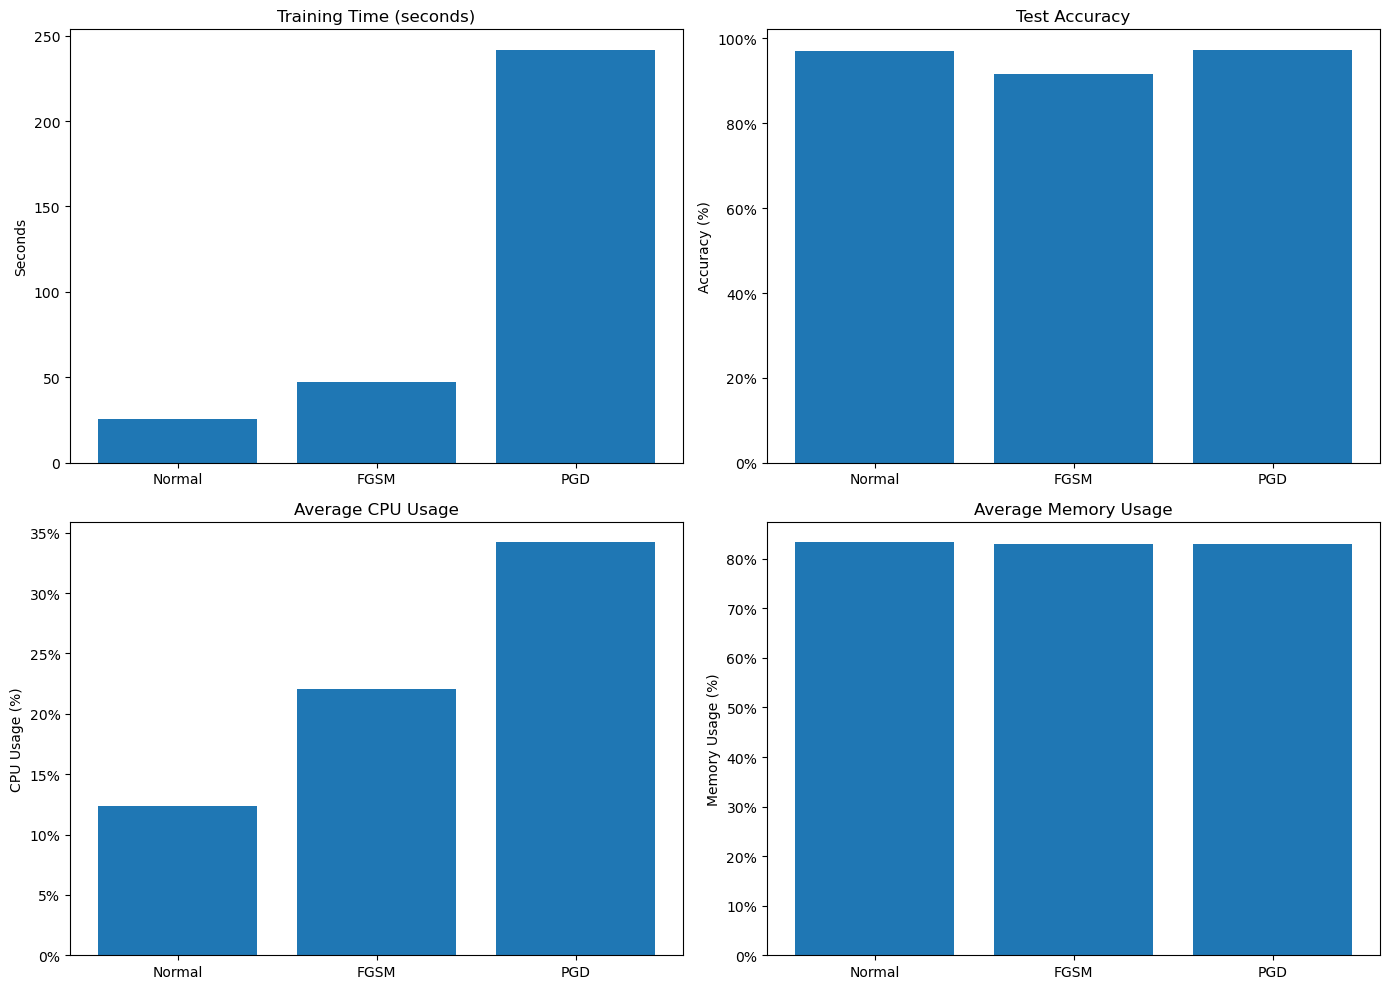

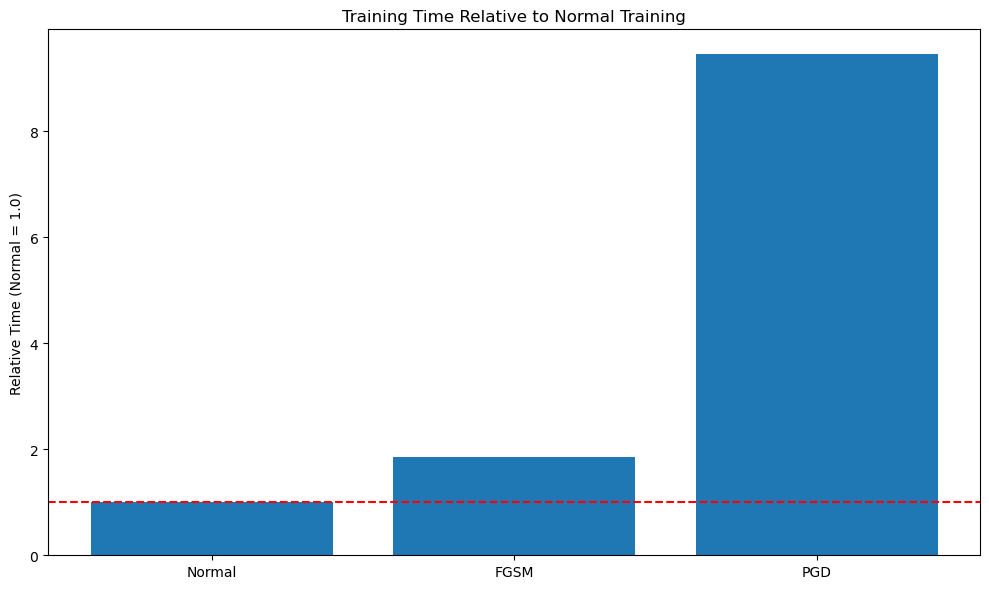


All benchmarks completed and results saved.


In [17]:
if __name__ == "__main__":
    results_df = benchmark_training_methods()
    results_df.to_csv('adversarial_training_metrics.csv', index=False) #save to CSV
    plot_metrics(results_df)
    print("\nAll benchmarks completed and results saved.")